In [6]:
import pymc3 as pm
import arviz as az
import theano.tensor as tt
import numpy as np
import matplotlib.pyplot as plt
import cdms2 as cdms
import MV2 as mv
import sys, os, glob
import cdutil,cdtime,genutil
import pandas as pd
import seaborn as sns
import matplotlib.cm as cm
from pymc3.distributions import Interpolated
from scipy import stats

#Impose uniform color scheme
def get_colors(forcing):
    colors={}
    colors["GHG"]=cm.tab10(2)
    colors["aer"]=cm.tab10(1)
    colors["nat"]=cm.tab10(3)
    colors["historical"]="k"
    colors["other"]=cm.tab10(4)
    colors["obs"]=cm.tab10(0)
    return colors[forcing]

## Function to turn posterior density into prior 
##(from https://docs.pymc.io/en/v3/pymc-examples/examples/pymc3_howto/updating_priors.html)
def from_posterior(param, samples):
    smin, smax = np.min(samples), np.max(samples)
    width = smax - smin
    x = np.linspace(smin, smax, 100)
    y = stats.gaussian_kde(samples)(x)

    # what was never sampled should have a small probability but not 0,
    # so we'll extend the domain and use linear approximation of density on it
    x = np.concatenate([[x[0] - 3 * width], x, [x[-1] + 3 * width]])
    y = np.concatenate([[0], y, [0]])
    return Interpolated(param, x, y)

# Specify the base period

In [8]:
base_start=1900
base_stop=1950
base_period=(str(base_start)+"-1-1",str(base_stop)+"-1-1")

Read in GISTEMP data

In [10]:
df=pd.read_csv("https://data.giss.nasa.gov/gistemp/tabledata_v4/GLB.Ts+dSST.csv",skiprows=[0])


In [11]:
allyears=df["Year"].values[:-1]
dat=df["J-D"].values[:-1].astype(float)
y=allyears[:int(np.where(allyears==2015)[0])]
gistemp=dat[:int(np.where(allyears==2015)[0])]

istart=int(np.where(allyears==base_start)[0])
istop=int(np.where(allyears==base_stop)[0])

gistemp_clim=np.average(gistemp[istart:istop+1])
gistemp=gistemp-gistemp_clim


# Read in in GISS data 

In [12]:
annual=True
if annual:
    func=lambda x: cdutil.YEAR(x)
    
else:
    func = lambda x:x
#Read in the simulation data
direc="/GISS_SINGLE_FORCING/"

GISS_simulations={}
for experiment in [x.split(".nc")[0] for x in os.listdir(direc)]:
    
    f=cdms.open(direc+experiment+".nc")
    try:
        ensemble=f("tas")#(time=("1880-1-1","2014-12-31"))
    except:
        ensemble=f('variable_12842')#(time=("1880-1-1","2014-12-31")) #kludge: forgot to label the piControl global mean anomalies as tas
    f.close()
    if experiment != "piControl":
        
        data=func(ensemble)(time=("1880-1-1","2014-12-31"))
        climatology=np.average(data(time=base_period))
        GISS_simulations[experiment]=data-climatology
    else:
        GISS_simulations[experiment]=func(ensemble)
        
#split picontrol into chunks
nmembers,nt=GISS_simulations["historical"].shape
t=np.arange(nt)+1850
piC=GISS_simulations["piControl"]
nt_piC=len(piC)
nchunks=int(nt_piC/nt)
piC_ensemble=piC[:nchunks*nt].reshape(nchunks,nt)
GISS_simulations["piControl"]=piC_ensemble
GISS_simulations["piControl_concatenated"]=piC

In [125]:
# Plot observations and model ensemble

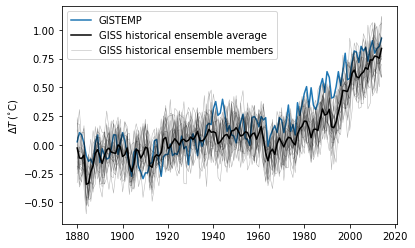

In [124]:
plt.plot(y,gistemp,label="GISTEMP")
plt.ylabel(r"$\Delta T \, (^{\circ}$C)")
plt.plot(y,np.average(GISS_simulations["historical"].asma(),axis=0),c="k",label="GISS historical ensemble average")

plt.plot(y,GISS_simulations["historical"][0].asma(),c="k",lw=.5,alpha=.3,label="GISS historical ensemble members")
tmp=[plt.plot(y,sim.asma(),c="k",lw=.5,alpha=.3) for sim in GISS_simulations["historical"][1:]]
plt.legend()

In [14]:
#Learning the forced signal from observations, no models
with pm.Model() as learnmodel:
    μ=pm.Normal("μ",0,10,shape=nt)
    σ=pm.HalfNormal("σ",10)
    obs=pm.Normal("obs",mu=μ,sigma=σ,observed=gistemp)

In [15]:
with learnmodel:
    learntrace=pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.
The acceptance probability does not match the target. It is 0.6655316929285005, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.5491890307237725, but should be close to 0.8. Try to increase the number of tuning steps.
There were 260 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8957725305476154, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


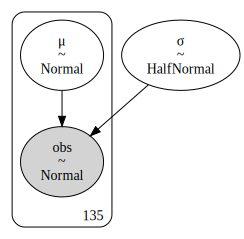

In [127]:
dot=pm.model_graph.model_to_graphviz(learnmodel)
dot
#dot.render(filename="learnmodel",directory='../TALK/',) 

What can we infer about the forced response if we don't assume anything other than white noise?

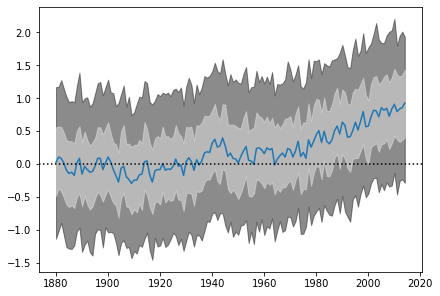

In [129]:

az.plot_hdi(y,learntrace.posterior.μ,smooth=False,hdi_prob=.90,color=cm.gray(.1))

az.plot_hdi(y,learntrace.posterior.μ,smooth=False,hdi_prob=.66,color=cm.gray(.9))
plt.plot(y,gistemp)
plt.axhline(0,c="k",ls=":")


# No uncertainty in forced response
Now, suppose the ensemble average of model simulations is the exact searched-for fingerprint:

In [130]:
#Simplest model: suppose we know forcing exactly
with pm.Model() as simplemodel:
    β=pm.Normal("β",0,10)
    σ=pm.HalfNormal("σ",10)
    μ=np.average( GISS_simulations["historical"],axis=0)
    μ_obs=β*μ
    obs=pm.Normal("obs",mu=μ_obs,sigma=σ,observed=gistemp)

In [19]:
with simplemodel:
    simpletrace=pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.


Posteriors on the scaling factor and internal variability

array([<AxesSubplot:title={'center':'β'}>,
       <AxesSubplot:title={'center':'σ'}>], dtype=object)

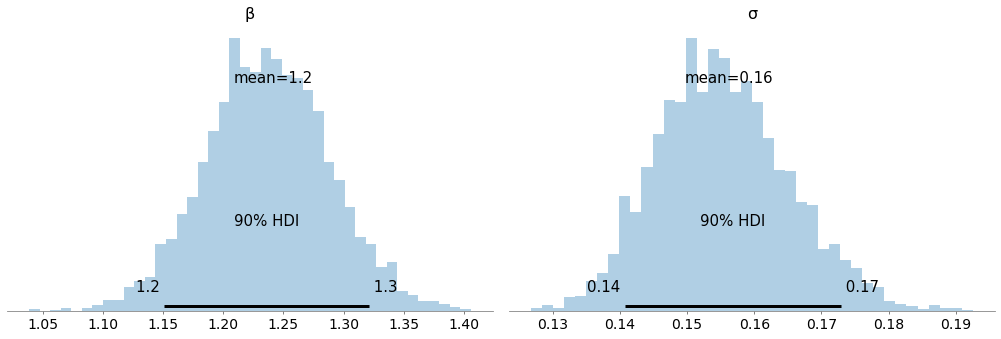

In [20]:
az.plot_posterior(simpletrace,var_names=["β","σ"],kind="hist",hdi_prob=.9)

# Incorporating piControl information
 First, we use chunks of piControl to train the noise model, fitting posteriors to $\sigma$.

Text(0, 0.5, '$\\Delta T \\, (^{\\circ}$C)')

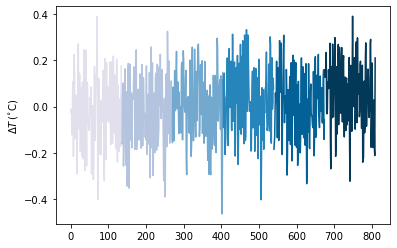

In [21]:
nenspic,ntpic=GISS_simulations["piControl"].shape
for i in range(nenspic):
    timeax=np.arange(ntpic)+i*ntpic
    plt.plot(timeax,GISS_simulations["piControl"][i].asma(),color=cm.PuBu(float(i+1)/nenspic))
plt.ylabel(r"$\Delta T \, (^{\circ}$C)")

In [22]:
#Use posteriors from model ensemble as priors for obs noise
with pm.Model() as piCmodel:
    σ=pm.HalfNormal("σ",10)
    cov=tt.pow(σ,2)*np.eye(nt)
    F=pm.MvNormal("likelihood_piC",mu=np.zeros(nt),cov=cov,\
                             observed= GISS_simulations["piControl"])

#This is a hack: need inferencedata object for az.compare, but I can't figure out how to make from_posterior() function work with inferencedata object.  Fix.
with piCmodel:
    piC_white_trace=pm.sample(return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 54 seconds.


### PiControl and historical data with uncertainty


In [90]:
# Priors from piControl?
with pm.Model() as histmodel_piC:
    β=pm.Normal("β",0,10)
    γ=pm.HalfNormal("γ",10)
    σ=from_posterior("σ",piCtrace["σ"])
    cov=tt.pow(γ*σ,2)*np.eye(nt)
    
    μ=pm.Normal("μ",0,10,shape=nt)
    #uncertain model forced response
    F=pm.MvNormal("F",mu=μ,cov=tt.pow(σ,2)*np.eye(nt),observed = GISS_simulations["historical"])
    μ_obs=β*μ
    obs=pm.MvNormal("obs",mu=μ_obs,cov=cov,observed=gistemp)

In [91]:
with histmodel_piC:
    trace_hist_pic_white=pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ, γ, β]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 241 seconds.


Text(0, 0.5, 'ΔT')

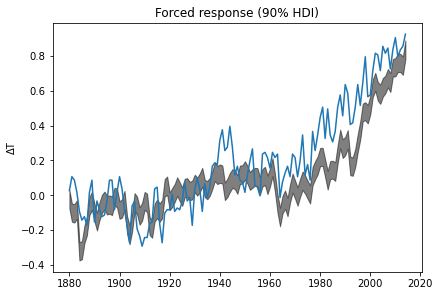

In [27]:
az.plot_hdi(y,trace_hist_pic_white.posterior.μ,smooth=False,hdi_prob=.9,color="k")
plt.title("Forced response (90% HDI)")
plt.plot(y,gistemp)
plt.ylabel("ΔT")

Posteriors for all other parameters: scaling parameters $\beta$ for (uncertain) external forcing and $\gamma$ for internal variability and internal variability $\sigma$ itself  (as simulated by the model)

array([<AxesSubplot:title={'center':'σ'}>,
       <AxesSubplot:title={'center':'γ'}>,
       <AxesSubplot:title={'center':'β'}>], dtype=object)

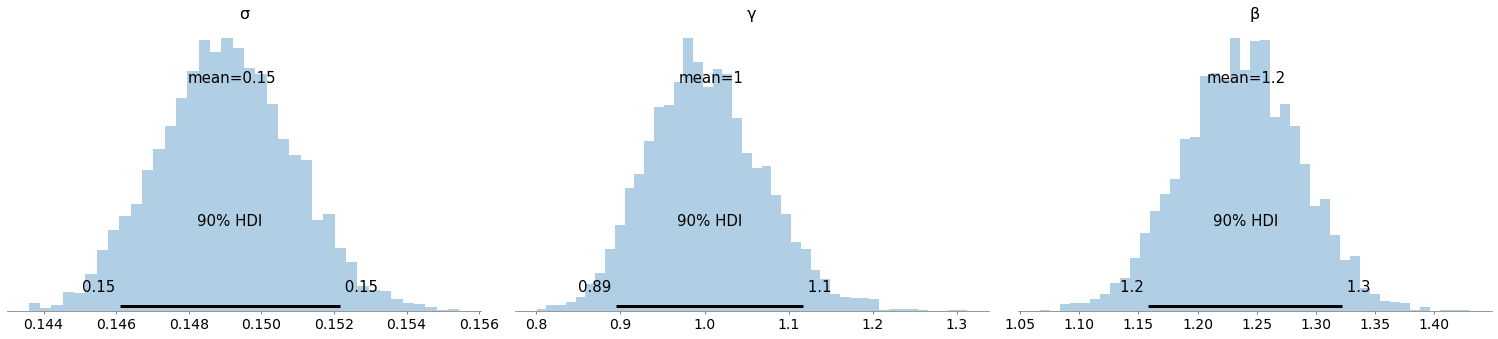

In [28]:
az.plot_posterior(trace_hist_pic_white.posterior,var_names=["σ","γ","β"],hdi_prob=.9,kind="hist")

Text(0.5, 1.0, 'Attributed forced component (90% HDI)')

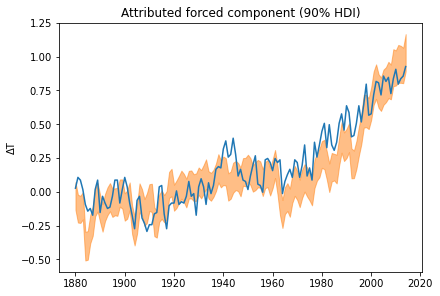

In [30]:
az.plot_hdi(y,trace_hist_pic_white.posterior.β*trace_hist_pic_white.posterior.μ,smooth=False,hdi_prob=.99)
plt.plot(y,gistemp)
plt.ylabel("ΔT")
plt.title("Attributed forced component (90% HDI)")

## Alternate noise models
The simple white noise model for internal variability in the observations is not necessarily applicable to some (perhaps most) climate data.  Fortunately, the Bayesian framework can easily accommodate more complex noise models by parameterizing the temporal structure of the covariance matrix.  For example, the covariance matrix of an short memory AR(1) process can be written as 
\begin{equation}
    U_{ij}^{AR(1)} = \frac{\sigma^2}{1-\phi^2} \phi^{|i-j|}.
\end{equation}
A long-memory process can be modeled using a fractionally differenced process with covariance matrix
\begin{equation}
U_{ij}^{FD} =\frac{\sigma^2 \sin(\pi \delta) \Gamma((1-2\delta) \Gamma(|i-j| + \delta)}{\pi \Gamma(|i-j|+ 1-\delta}
\end{equation}
In both cases, the additional structure added to the covariance matrix results in only one additional parameter to be estimated.  

Let's do AR(1) noise here

In [31]:
with pm.Model() as piC_AR1:
    σ=pm.HalfNormal("σ",10)
    ϕ=pm.Uniform("ϕ",-1,1)
    #AR(1) covariance matrix
    δ=np.arange(nt)
    imj=np.abs(np.subtract.outer(δ,δ))
    cov=tt.pow(σ,2)/(1-tt.pow(ϕ,2))*tt.pow(ϕ,imj)
    
    chol=tt.slinalg.cholesky(cov)
    
    
    #use piControl to train the noise model

    F=pm.MvNormal("likelihood_piC",mu=np.zeros(nt),chol=chol,\
                             observed= GISS_simulations["piControl"])


In [32]:
with piC_AR1:
    piC_AR1_trace=pm.sample(return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϕ, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 87 seconds.


In [33]:
#Inferencedata objects for both noise models for use by az.compare
with piC_AR1:
    piC_AR1_inference=pm.sample(return_inferencedata=True)
with piCmodel:
    piC_white_inference=pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϕ, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 88 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 51 seconds.
The acceptance probability does not match the target. It is 0.878769404299057, but should be close to 0.8. Try to increase the number of tuning steps.


### Which noise model is better?
Compare models based on their expected log pointwise predictive density (ELPD).

The ELPD is estimated either by Pareto smoothed importance sampling leave-one-out cross-validation (LOO) dx.doi.org/10.1111/1467-9868.00353

In [42]:
az.compare({"AR(1) noise model":piC_AR1_inference,"Gaussian noise model":piC_white_inference})

/Users/kmarvel/Applications/anaconda3/envs/machine_learning/lib/python3.9/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
AR(1) noise model,0,441.979492,0.933698,0.000000,1.0,11.140719,0.0000,False,log
Gaussian noise model,1,402.101081,0.379714,39.878411,0.0,10.837992,5.9266,False,log


posteriors for AR(1) red noise model

array([<AxesSubplot:title={'center':'σ'}>,
       <AxesSubplot:title={'center':'ϕ'}>], dtype=object)

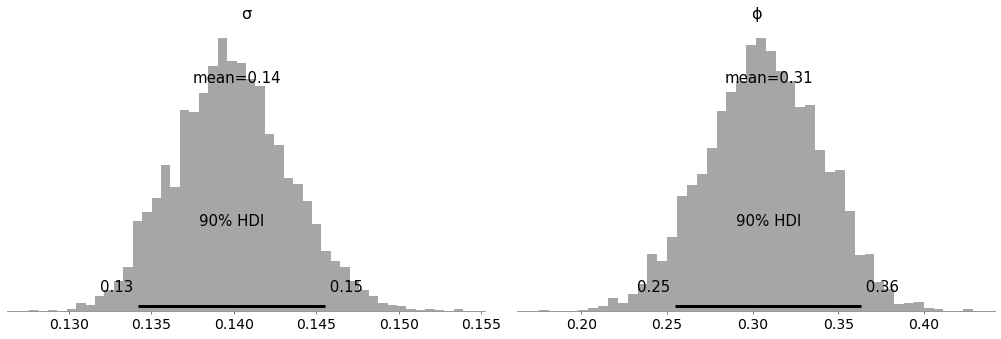

In [846]:
az.plot_posterior(piC_AR1_trace,var_names=["σ","ϕ"],hdi_prob=.9,kind="hist",color="k")

## Uncertain historical forced response, AR(1) noise

In [35]:
with pm.Model() as piC_AR1_hist:

    σ=from_posterior("σ",piC_AR1_trace["σ"])
    ϕ=from_posterior("ϕ",piC_AR1_trace["ϕ"])
    #observed scaling factors
    β=pm.Normal("β",0,10)
    γ=pm.HalfNormal("γ",10)
    #assume the autocorrelation in the obs is the same as that in the models
    
    
    
    #AR(1) covariance matrix
    δ=np.arange(nt)
    imj=np.abs(np.subtract.outer(δ,δ))
    cov=tt.pow(σ,2)/(1-tt.pow(ϕ,2))*tt.pow(ϕ,imj)

    chol=tt.slinalg.cholesky(cov)
    
    covobs=tt.pow(γ*σ,2)/(1-tt.pow(ϕ,2))*tt.pow(ϕ,imj)

    chol_obs=tt.slinalg.cholesky(covobs)
    
    μ=pm.Normal("μ",0,10,shape=nt)
    
    F=pm.MvNormal("likelihood_hist",mu=μ,chol=chol,\
                             observed= GISS_simulations["historical"])
    μ_obs=β*μ
    obs=pm.MvNormal("obs",mu=μ_obs,chol=chol_obs,observed=gistemp)
 


In [36]:
with piC_AR1_hist:
    trace_hist_pic_ar1=pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, γ, β, ϕ, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 278 seconds.


Text(0.5, 0, 'β')

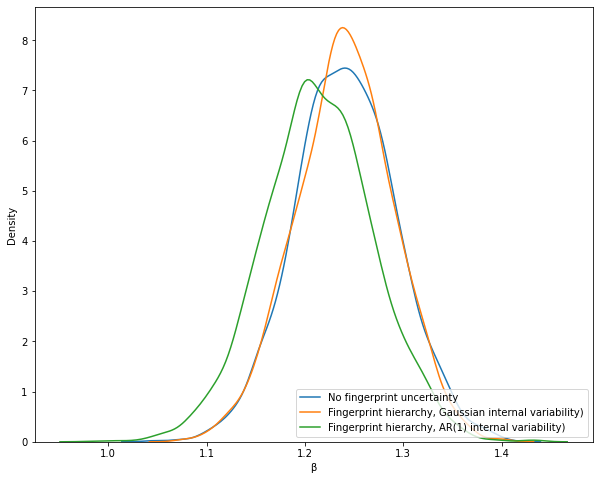

In [122]:
plt.figure(figsize=(10,8))
sns.kdeplot(simpletrace.posterior.β.values.flatten(),label="No fingerprint uncertainty")
sns.kdeplot(trace_hist_pic_white.posterior.β.values.flatten(),label="Fingerprint hierarchy, Gaussian internal variability)")
sns.kdeplot(trace_hist_pic_ar1.posterior.β.values.flatten(),label="Fingerprint hierarchy, AR(1) internal variability)")
plt.legend(loc=4)
plt.xlabel("β")

array([<AxesSubplot:title={'center':'β'}>,
       <AxesSubplot:title={'center':'γ'}>,
       <AxesSubplot:title={'center':'σ'}>,
       <AxesSubplot:title={'center':'ϕ'}>], dtype=object)

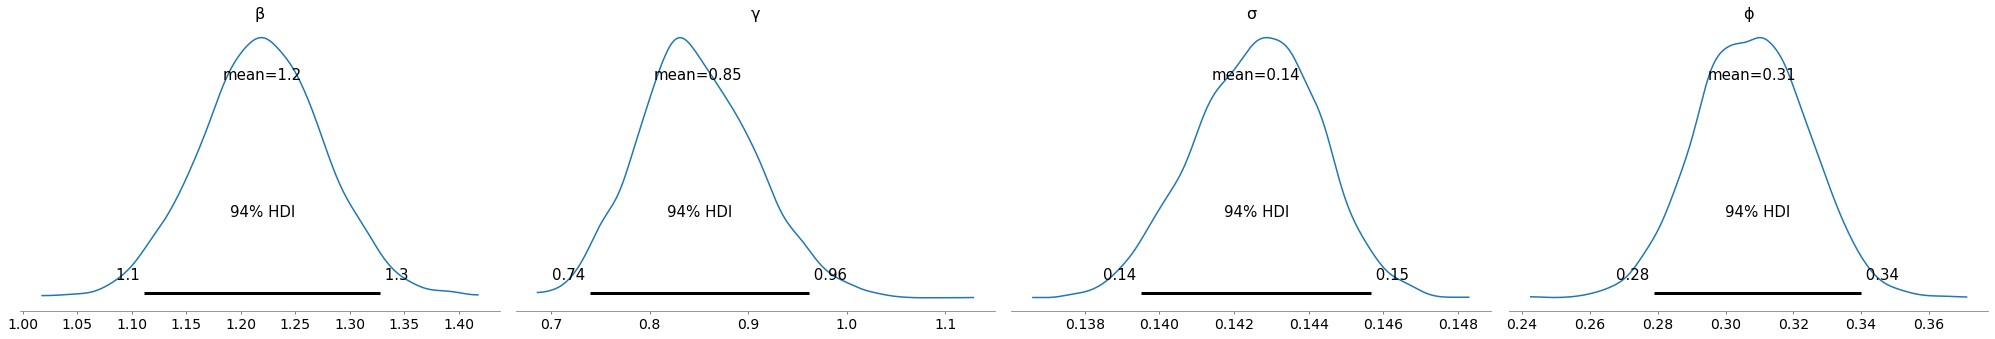

In [612]:
az.plot_posterior(picar1histtrace,var_names=["β","γ","σ","ϕ"])

## Multiple external forcings
Use DAMIP ensembles of single-forcing simulations

In [132]:
#Multiple external forcings
external_forcings = ["aer","GHG","nat"]

with pm.Model() as allforcingsmodel:
    #Coefficients of forced responses
    β={}
    #Latent true forced responses
    μ={}
    for forcing in external_forcings:
        β[forcing]=pm.Normal("β"+forcing,0,10)
        μ[forcing]=pm.Normal("μ"+forcing,0,10,shape=nt)
    β["other"]=pm.Normal("βother",0,10)
    μ["other"]=pm.Normal("μother",0,10,shape=nt)
    
    #Internal variability
    σ=pm.HalfNormal("σ",10)
    σmod=pm.HalfNormal("σmod",10)
    
    #uncertain model forced responses
    F={}
    for forcing in external_forcings:
        F[forcing]=pm.Normal("F"+forcing,mu=μ[forcing],sigma=σmod,shape=nt,\
                             observed = GISS_simulations["hist-"+forcing])
    μ_historical = μ["other"]
    for forcing in external_forcings:
        μ_historical += μ[forcing]
    Fhistorical = pm.Normal("Fhistorical",mu = μ_historical,sigma=σmod,shape=nt, \
                            observed=GISS_simulations["historical"])
    

    
    #Observed mean
    μ_obs= β["other"]*μ["other"]
    for forcing in external_forcings:
        μ_obs += β[forcing]*μ[forcing]
    
    obs=pm.Normal("obs",mu=μ_obs,sigma=σ,observed=gistemp)

In [133]:
with allforcingsmodel:
    allforcingstrace=pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σmod, σ, μother, βother, μnat, βnat, μGHG, βGHG, μaer, βaer]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 52 seconds.


Plot the highest posterior density interval (90%) for all forced responses estimated from DAMIP ensembles

In [131]:
az.plot_hdi(y,allforcingstrace.posterior.μGHG,smooth=False,color=cm.tab10(2),hdi_prob=.9)
az.plot_hdi(y,allforcingstrace.posterior.μaer,smooth=False,color=cm.tab10(1),hdi_prob=.9)
az.plot_hdi(y,allforcingstrace.posterior.μnat,smooth=False,color=cm.tab10(3),hdi_prob=.9)
az.plot_hdi(y,allforcingstrace.posterior.μother,smooth=False,color=cm.tab10(4),hdi_prob=.9)
plt.axhline(0,ls=":",c="k")
plt.ylabel("ΔT")

NameError: name 'allforcingstrace' is not defined

Scaling factors for each external forcing

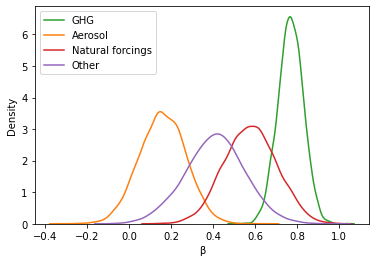

In [527]:
sns.kdeplot(allforcingstrace.posterior.βGHG.values.flatten(),color=cm.tab10(2),label="GHG")
sns.kdeplot(allforcingstrace.posterior.βaer.values.flatten(),color=cm.tab10(1),label="Aerosol")
sns.kdeplot(allforcingstrace.posterior.βnat.values.flatten(),color=cm.tab10(3),label="Natural forcings")
sns.kdeplot(allforcingstrace.posterior.βother.values.flatten(),color=cm.tab10(4),label="Other")
plt.xlabel("β")
plt.legend()

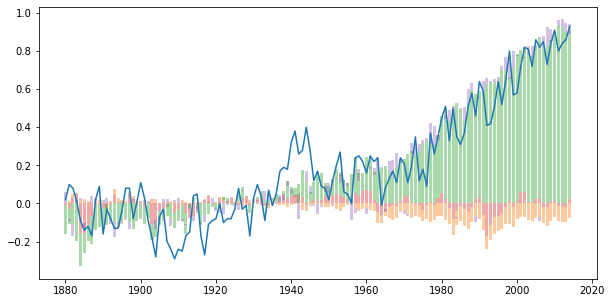

In [529]:
#Plot forced contributions (posterior median)
plt.figure(figsize=(10,5))
bottom_neg=np.zeros(nt)
bottom_pos=np.zeros(nt)
bottom=np.zeros(nt)
for forcing in ["nat","aer","GHG","other"]:
    toplot=np.median(scaled[forcing],axis=[0,1])
    bottom=np.where(toplot<0,bottom_neg,bottom_pos)
    plt.bar(y,toplot,color=get_colors(forcing),bottom=bottom,alpha=.4)
    
    bottom_neg=np.where(toplot<0,toplot,bottom_neg)
    bottom_pos=np.where(toplot>0,toplot,bottom_pos)
plt.plot(y,gistemp)

Greenhouse gases made 1951-1980 warmer than years previously, and colder than subsequent years.  Aerosols had the reverse effect.  Natural forcings had essentially no impact except in years corresponding to large volcanic eruptions.

# Is there a common forced response across ensemble members?


In [63]:
experiment="historical"

#prepare the data
forced_ensemble = GISS_simulations[experiment]
nmembers,nt=forced_ensemble.shape
t=np.arange(nt)+1850
piC=GISS_simulations["piControl"]
nt_piC=len(piC)
nchunks=int(nt_piC/nt)
piC_ensemble=piC[:nchunks*nt].reshape(nchunks,nt)



In [135]:
# Plot of ensemble members 

Text(0, 0.5, 'ΔT')

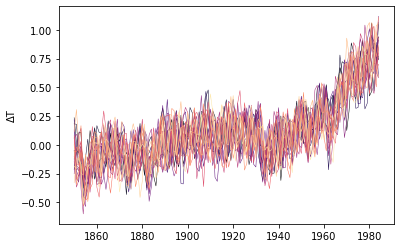

In [134]:
tmp=[plt.plot(t,forced_ensemble[i].asma(),"k",alpha=1,lw=.5,c=cm.magma(float(i)/nmembers)) for i in range(nmembers)]
#plt.plot(t,np.average(forced_ensemble.asma(),axis=0),c="k",lw=3)
plt.ylabel("ΔT")

# Fixed Effect 
The individual forced ensemble members $m_i$ reflect a common forced response $\mu$ and internal variability, modeled as white noise:
\begin{equation}
m_i \sim N(\mu,\sigma)
\end{equation}
Moreover, we assume the pre-industrial control simulations $p_i$ have the same internal variability and no forced response:
$$ p_i \sim N(0,\sigma) $$

In [75]:
with pm.Model() as fixedeffect:
    #Prior on latent forced response
    μ=pm.Normal("μ",np.zeros_like(nt),10,shape=nt)
    #Prior on model-simulated internal variability
    #σ=pm.HalfNormal("σ",10)
    σ=from_posterior("σ",piCtrace["σ"])
    ensemble_likelihood=pm.Normal("ensemble_likelihood",μ,σ,observed=forced_ensemble)
    #piC_likelihood=pm.Normal("piC_likelihood",0,σ,observed=piC_ensemble)
    
with fixedeffect:
    fixedtrace=pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.


# Random effects 
The individual forced ensemble members $m_i$ reflect a forced response $\theta_i$ and internal variability, modeled as white noise:
$$ m_i \sim N(\theta_i,\sigma) $$
The forced responses in each individual simulation are assumed to be normally distributed around a common response
$$\Theta_i \sim N(\mu,\tau)$$
Moreover, we assume the pre-industrial control simulations $p_i$ have the same internal variability and no forced response:
$$ p_i \sim N(0,\sigma) $$

In [76]:
#Is there evidence for nonhomogeneity?
with pm.Model() as randomeffect:
    #prior on true common forced response
    μ=pm.Normal("μ",np.zeros_like(nt),10,shape=nt)
    #prior on Inter-ensemble member variation
    τ=pm.HalfNormal("τ",10)
    #Prior on Common internal variability
   # σ = pm.HalfNormal("σ",10)
    σ=from_posterior("σ",piCtrace["σ"])
    #Forced response in each ensemble member
    θ=pm.Normal('θ',μ,sd=τ,shape=forced_ensemble.shape)
    ensemble_likelihood=pm.Normal("ensemble_likelihood",θ,sd=σ,observed=forced_ensemble)
    #piC_likelihood = pm.Normal("piC_likelihood",np.zeros_like(nt),sd=σ,observed=piC_ensemble)

In [77]:
with randomeffect:
    randomtrace=pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ, σ, τ, μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 50 seconds.
The acceptance probability does not match the target. It is 0.6266587159933013, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.2821318186620296, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


<AxesSubplot:>

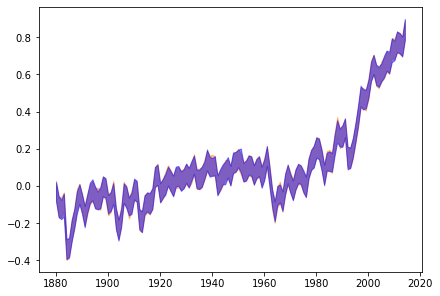

In [78]:
az.plot_hdi(y,fixedtrace.posterior.μ,smooth=False,hdi_prob=.9)
az.plot_hdi(y,randomtrace.posterior.μ,smooth=False,hdi_prob=.9,color="b")

<AxesSubplot:title={'center':'τ'}>

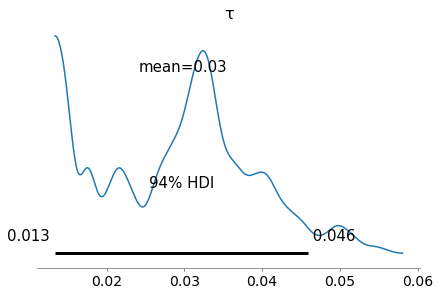

In [79]:
#posterior for inter-ensemble spread in forced response
az.plot_posterior(randomtrace.posterior.τ)

In [83]:
#A higher log-score (or a lower deviance) indicates a model with better predictive accuracy
az.waic(fixedtrace,var_name="ensemble_likelihood")

/Users/kmarvel/Applications/anaconda3/envs/machine_learning/lib/python3.9/site-packages/arviz/stats/stats.py:1405: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 4000 by 2700 log-likelihood matrix

          Estimate       SE
elpd_waic  1226.41    30.90
p_waic      132.87        -

There has been a warning during the calculation. Please check the results.

In [82]:
az.waic(randomtrace,var_name="ensemble_likelihood")

/Users/kmarvel/Applications/anaconda3/envs/machine_learning/lib/python3.9/site-packages/arviz/stats/stats.py:1405: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 4000 by 2700 log-likelihood matrix

          Estimate       SE
elpd_waic  1229.81    30.53
p_waic      233.93        -

There has been a warning during the calculation. Please check the results.

In [85]:
#Constitutes (some, weak) evidence for a random effect?
az.compare({"fixed":fixedtrace,"random":randomtrace})

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
random,0,1227.017589,236.719901,0.000000,0.798155,30.596455,0.000000,False,log
fixed,1,1226.101613,133.177342,0.915976,0.201845,30.910429,1.752372,False,log


## Volcanic forcing: does it depend on background state?
Restrict forced response to years where we know there was a volcanic eruption

In [13]:
lower=az.hdi(randomtrace.posterior.μ,hdi_prob=.99).μ[:,0]
upper=az.hdi(randomtrace.posterior.μ,hdi_prob=.99).μ[:,1]
response_present=np.where(np.sign(lower*upper)>0)[0]
t[response_present]

array([1884, 1885, 1886, 1887, 1903, 1904, 1905, 1909, 1913, 1914, 1959,
       1963, 1964, 1983, 1987, 1991, 1992, 1993, 1994, 1995, 1996])

Text(0, 0.5, 'ΔT')

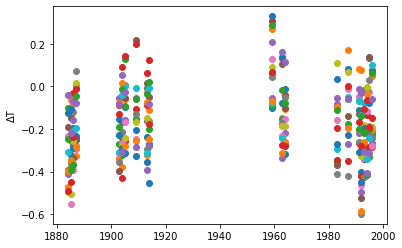

In [53]:
tmp=[plt.plot(t[response_present],forced_ensemble.asma()[:,response_present][i],"o") for i in range(nmembers)]
plt.ylabel("ΔT")

In [15]:
pinatubo=response_present[int(np.where(t[response_present]==1991)[0]):]
#prepare the data
forced_ensemble_pinatubo = GISS_simulations[experiment].asma()[:,pinatubo]
nmembers_pinatubo,nt_pinatubo=forced_ensemble_pinatubo.shape


nchunks_pinatubo=int(nt_piC/nt_pinatubo)
piC_ensemble_pinatubo=piC[:nchunks_pinatubo*nt_pinatubo].reshape(nchunks_pinatubo,nt_pinatubo)

In [16]:
#Is there evidence for nonhomogeneity?
with pm.Model() as randomeffect_pinatubo:
    #prior on true common forced response
    μ=pm.Normal("μ",np.zeros_like(nt_pinatubo),10,shape=nt_pinatubo)
    #prior on Inter-ensemble member variation
    τ=pm.HalfNormal("τ",10)
    #Prior on Common internal variability
    σ = pm.HalfNormal("σ",10)
    #Forced response in each ensemble member
    θ=pm.Normal('θ',μ,sd=τ,shape=forced_ensemble_pinatubo.shape)
    obs=pm.Normal("obs",θ,sd=σ,observed=forced_ensemble_pinatubo)
    piC_likelihood = pm.Normal("piC_likelihood",np.zeros_like(nt_pinatubo),sd=σ,observed=piC_ensemble_pinatubo)

In [17]:
with randomeffect_pinatubo:
    tracepinatubo=pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ, σ, τ, μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 28 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9205450671050738, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


<AxesSubplot:title={'center':'τ'}>

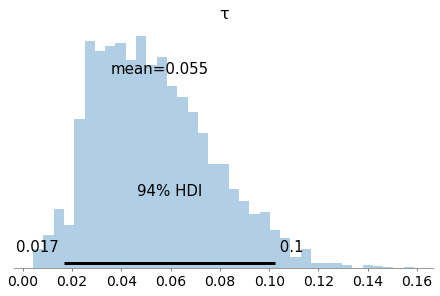

In [18]:
az.plot_posterior(tracepinatubo.posterior.τ,kind="hist")

<AxesSubplot:title={'center':'σ'}>

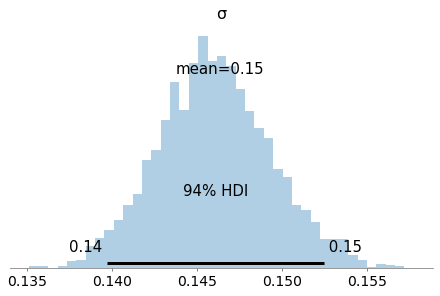

In [19]:
az.plot_posterior(tracepinatubo.posterior.σ,kind="hist")

<AxesSubplot:>

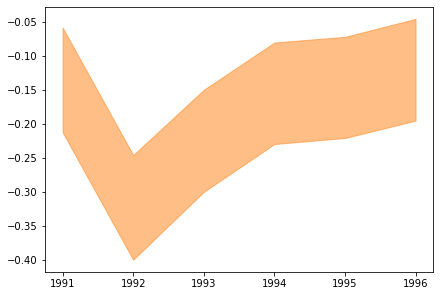

In [20]:
az.plot_hdi(np.arange(nt_pinatubo)+1991,tracepinatubo.posterior.μ,smooth=False)